C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\anaconda\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


-------------------BEGIN--------------------------------
-----------------draw_boxes-----------------------------------draw_boxes-----------------
---------------------------------------0-------------------------------
Young: 99.91923570632935%
Young 99.92% ===> 300,96
----------------------------------------------------------------------
-------------END--------------------------------------


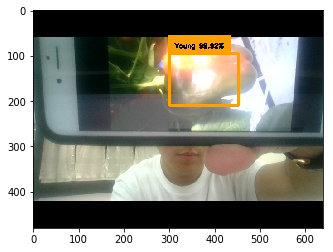

In [1]:
# predict
import os
import argparse
import json
import cv2
from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from keras.models import load_model
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# # input_path   = 'farmbot_test' # TIGER 20180810_三民路[(002833)2018-09-25-16-07-10].jpg
# input_path   = '11112018_150633.mp4'

# output_path  = 'output/'
# makedirs(output_path)

# Set some parameter
net_h, net_w = 416, 416 # a multiple of 32, the smaller the faster
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [16,26, 28,48, 40,63, 43,37, 47,86, 64,84, 69,113, 88,139, 119,191] # TIGER
# labels = ["1_mediumcircle", "4_mediumsquare", "6_patch"] # TIGER
labels = ["Flower","Young","Matured","Covered"] # TIGER

# Load the model
infer_model = load_model('kfarmbot_train.h5') # TIGER # TIGER
16,26, 28,48, 40,63, 43,37, 47,86, 64,84, 69,113, 88,139, 119,191
# Predict bounding boxes 
###############################
#   Predict bounding boxes 
###############################

cap = cv2.VideoCapture(0)
while(1):
# get a frame
    ret, image = cap.read()
# show a frame
    cv2.imshow("capture", image)
    cv2.imwrite(r"C:\Users\user\Downloads\keras-yolo3\abc.jpg", image)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        #cv2.imwrite(r"C:\Users\user\Downloads\keras-yolo3\abc.jpg", image)
        #k = cv2.waitKey(10)
        #if k == 27:
        break        
#     break
cap.release()
cv2.destroyAllWindows()

print("-------------------BEGIN--------------------------------") 
# infer_model = load_model('kfarmbot_train.h5') # TIGER # TIGER

image = cv2.imread(r"C:\Users\user\Downloads\keras-yolo3\abc.jpg")

# image = cv2.imread(image_path)
# print(image_path)

# predict the bounding  boxes
boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors, obj_thresh, nms_thresh)[0]

# draw bounding boxes on the image using labels
draw_boxes(image, boxes, labels, obj_thresh) 

# write the image with bounding boxes to file
output_img_path = r"C:\Users\user\Downloads\keras-yolo3\abc_predict.jpg"
cv2.imwrite(output_img_path, np.uint8(image))
img = cv2.imread(output_img_path)[:,:,::-1]
plt.imshow(img)


print("-------------END--------------------------------------")    
# raise ValueError('A very specific bad thing happened.')


In [ ]:
# raise ValueError('A very specific bad thing happened.')
####################################################################


# image = cv2.imread(image_path)   #########################

# predict the bounding boxes
boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors, obj_thresh, nms_thresh)[0]

# draw bounding boxes on the image using labels
draw_boxes(image, boxes, labels, obj_thresh) 

# write the image with bounding boxes to file
output_img_path = r"C:\Users\user\Downloads\keras-yolo3\abc_predict.jpg"
cv2.imwrite(output_img_path, np.uint8(image))
img = cv2.imread(output_img_path)[:,:,::-1]
plt.imshow(img)     

if input_path[-4:] == '.mp4': # do detection on a video  
    video_out = output_path + input_path.split('/')[-1]
    video_reader = cv2.VideoCapture(input_path)
    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

    video_writer = cv2.VideoWriter(video_out,
                           cv2.VideoWriter_fourcc(*'H264'), 
                           24.0, 
                           (frame_w, frame_h))
    # the main loop
    batch_size  = 1
    images      = []
    start_point = 0 #%
    show_window = False
    for i in tqdm(range(nb_frames)):
        _, image = video_reader.read()
        if image is None:
            continue
        if (float(i+1)/nb_frames) > start_point/100.:
            images += [image]

            if (i%batch_size == 0) or (i == (nb_frames-1) and len(images) > 0):
                # predict the bounding boxes
                batch_boxes = get_yolo_boxes(infer_model, images, net_h, net_w, anchors, obj_thresh, nms_thresh)

                for i in range(len(images)):
                    # draw bounding boxes on the image using labels
                    draw_boxes(images[i], batch_boxes[i], labels, obj_thresh)   

                    # show the video with detection bounding boxes          
                    if show_window: cv2.imshow('video with bboxes', images[i])  

                    # write result to the output video
                    video_writer.write(images[i]) 
                images = []
            if show_window and cv2.waitKey(1) == 27: break  # esc to quit

    if show_window: cv2.destroyAllWindows()
    video_reader.release()
    video_writer.release()       
else: # do detection on an image or a set of images
    image_paths = []

    if os.path.isdir(input_path): 
        for inp_file in os.listdir(input_path):
            image_paths += [input_path + '/' +inp_file] # image_paths += [input_path + inp_file]
    else:
        image_paths += [input_path]

    image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg','.JPG', '.png', 'JPEG'])]

    # the main loop
    for image_path in image_paths:
        image = cv2.imread(image_path)
        print(image_path)

        # predict the bounding  boxes
        boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors, obj_thresh, nms_thresh)[0]

        # draw bounding boxes on the image using labels
        draw_boxes(image, boxes, labels, obj_thresh) 

        # write the image with bounding boxes to file
        output_img_path = output_path + image_path.split('/')[-1]
        cv2.imwrite(output_img_path, np.uint8(image))
        img = cv2.imread(output_img_path)[:,:,::-1]
        plt.imshow(img)
